# X-AI with SHAP for Wine Quality Regression

In [1]:
# import packages
import pandas as pd 
import shap
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

### Load dataset

In [3]:
# load dataset
data = pd.read_csv("dataset/winequality-red.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
# metadata information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [5]:
# load the name of features
feature_names = data.columns.tolist()
feature_names

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

In [6]:
# fill with zero missing values 
data.fillna(0, inplace=True)
data.shape

(1599, 12)

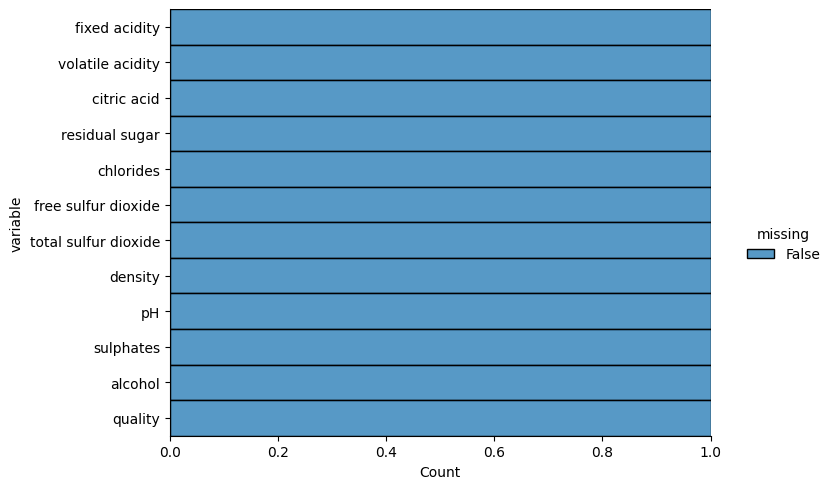

In [7]:
# check missing data
sns.displot(
    data = data.isna().melt(value_name="missing"),
    y = "variable",
    hue = "missing",
    multiple = "fill",
    aspect = 1.5
)

plt.show()

### Preprocessing step

In [8]:
# split independent and dependent variables
x = data.drop(columns=["quality"])
y = data["quality"]

In [9]:
# train-test split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Train step

Training Random Forest + hyperparameter optimization

In [10]:
# import packages
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# define grid of parameters
dict_params = {
    "n_estimators": [100, 200, 500, 1000], 
    "max_depth": [10, 20, 30, 50],
    "criterion": ["squared_error", "absolute_error", "poisson"]
}

In [11]:
# define classifier 
grid_rf = GridSearchCV(RandomForestRegressor(random_state = 42),    # regressor model
                       param_grid = dict_params,    # dict of parameters
                       cv = 5,  # 5-fold cross-validation
                       n_jobs = -1 # all processors processing in parallel
                    )
# fit Random Forest 
grid_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error',
                                       'poisson'],
                         'max_depth': [10, 20, 30, 50],
                         'n_estimators': [100, 200, 500, 1000]})

In [12]:
# take the best model
best_model = grid_rf.best_estimator_
best_params = grid_rf.best_params_
best_score = grid_rf.best_score_

In [13]:
# check the best model
print(best_model)

RandomForestRegressor(max_depth=30, n_estimators=500, random_state=42)


In [15]:
# check the best score
print("best score: ", best_score)

best score:  0.435890104094742


The result in conclusion, indicates that the model is not very efficient  
Let's go check why using SHAP

### Explaination of model with SHAP

SHAP values for global explanations

In [16]:
# define shap explainer object
explainer = shap.Explainer(best_model, x_test)

In [17]:
# calculate shap values 
shap_values = explainer(x_test)

 99%|===================| 317/320 [00:58<00:00]        

In [18]:
shap_values[0]

.values =
array([-0.01125245, -0.08418687,  0.01603663,  0.01395372, -0.08951656,
        0.01162826, -0.00816161, -0.03827113,  0.00240535,  0.05159515,
       -0.28865055])

.base_values =
5.726719999999951

.data =
array([ 7.7   ,  0.56  ,  0.08  ,  2.5   ,  0.114 , 14.    , 46.    ,
        0.9971,  3.24  ,  0.66  ,  9.6   ])

#### Global explainability
Global explainability using feature importance bar plots

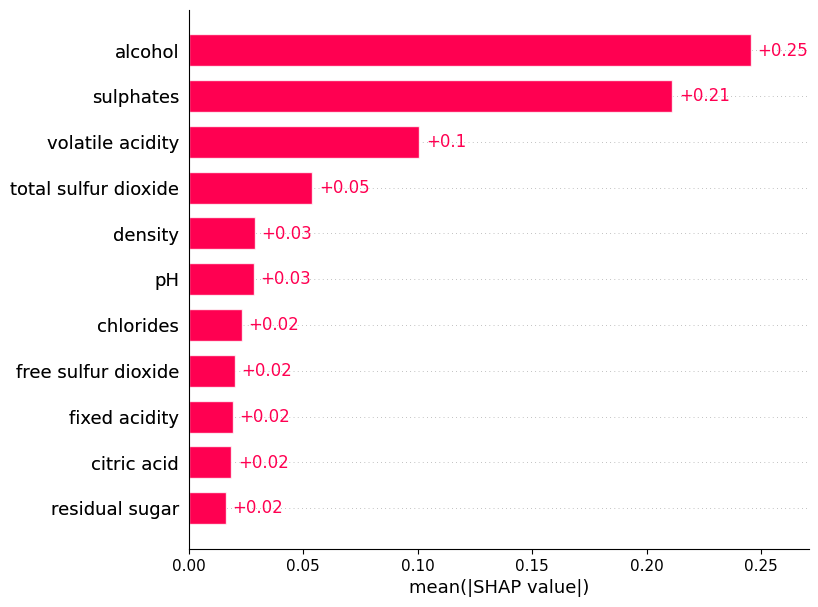

In [19]:
shap.plots.bar(shap_values, show = True, max_display=12)

Global explainability using summary plots

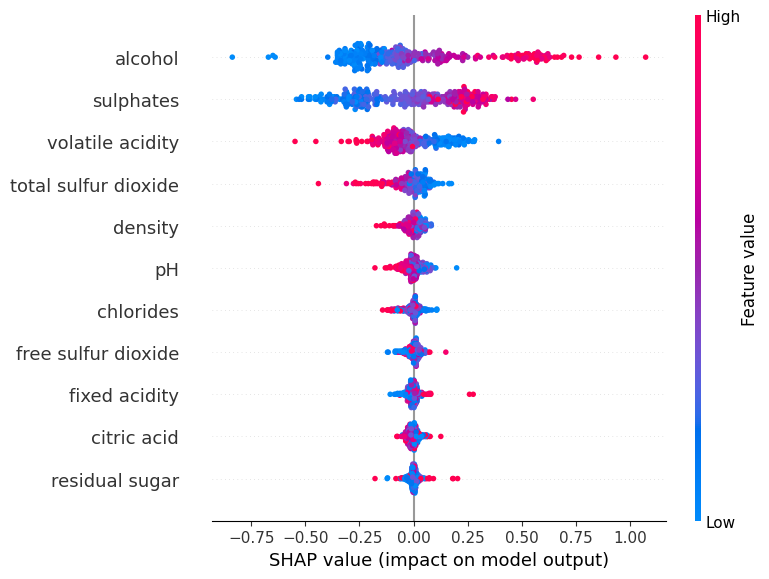

In [38]:
shap.summary_plot(shap_values, x_test)

Gobal explainability using heatmap plots

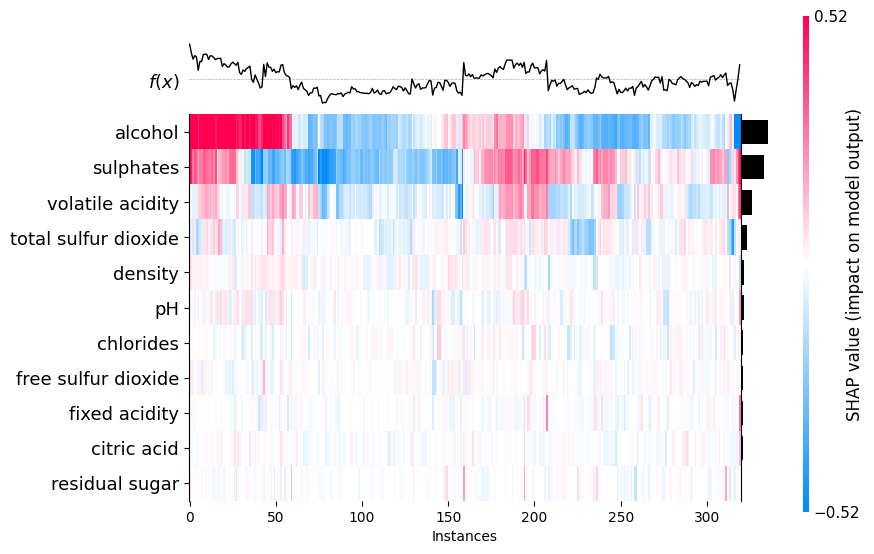

In [46]:
shap.plots.heatmap(shap_values, max_display = 12)

### Local Explainability

In [40]:
local_explainer = shap.TreeExplainer(best_model)
local_shap_values = local_explainer.shap_values(x_test)

Local explainability using force plots

In [41]:
# Choose the index of the instance to explain
instance_index = 0

In [42]:
# Generate a force plot for the chosen instance
shap.initjs()
shap.force_plot(local_explainer.expected_value, local_shap_values[instance_index], x_test.iloc[instance_index])

Local explainability using waterfall plots

In [43]:
# Create an Explanation object for a specific instance
local_explanation = shap.Explanation(local_shap_values[instance_index], local_explainer.expected_value,
                                     feature_names = feature_names)

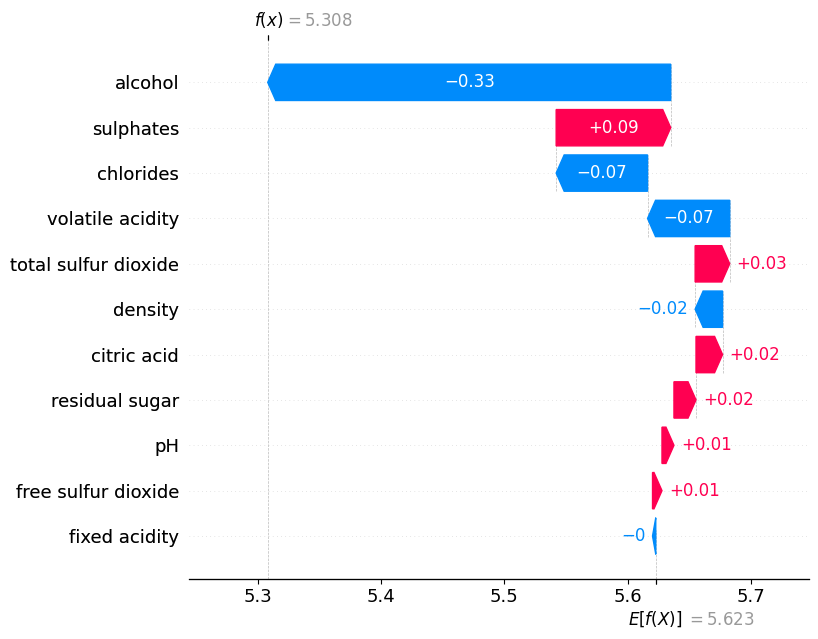

In [45]:
shap.initjs()
shap.waterfall_plot(local_explanation, max_display = 12)
plt.show()

Local explainability using decision plots

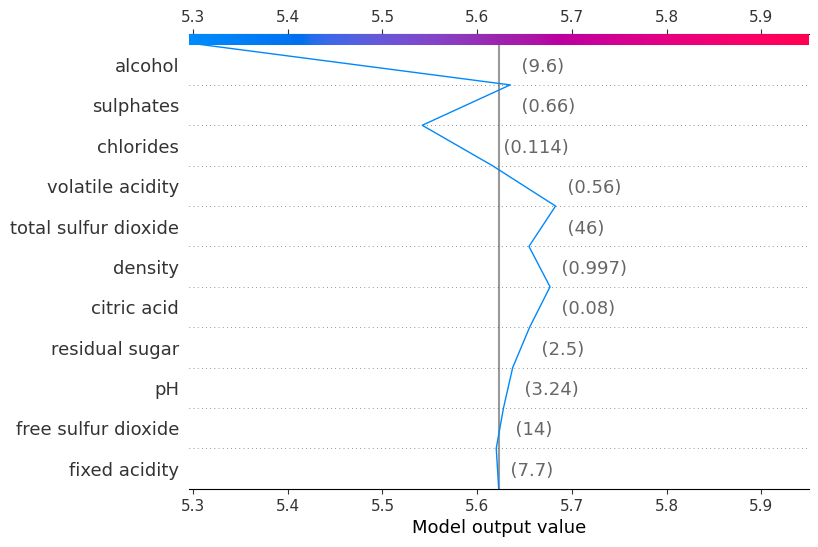

In [52]:
shap.initjs()
shap.decision_plot(local_explainer.expected_value, local_shap_values[instance_index],
                   features = x_test.iloc[instance_index])
plt.show()